In [ ]:
!pip install tensorflow

import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
print("Number of GPUs available : ", len(tf.config.list_physical_devices('GPU')))

tf.test.gpu_device_name()

Number of GPUs available :  1


'/device:GPU:0'

In [ ]:
path = '/content/drive/MyDrive/Brats17TrainingData/brats_2013_pat0001_1slice63.npz'

MRI_image = np.load(path)

image = np.transpose(MRI_image['a'],(1,2,0))
                      

ground_truth = MRI_image['b'].astype(np.uint8)

print(np.unique(ground_truth))

n_classes = 5

ground_truth = to_categorical(ground_truth, num_classes=n_classes)

print(ground_truth.shape)

[0 1 2 3 4]
(240, 240, 5)


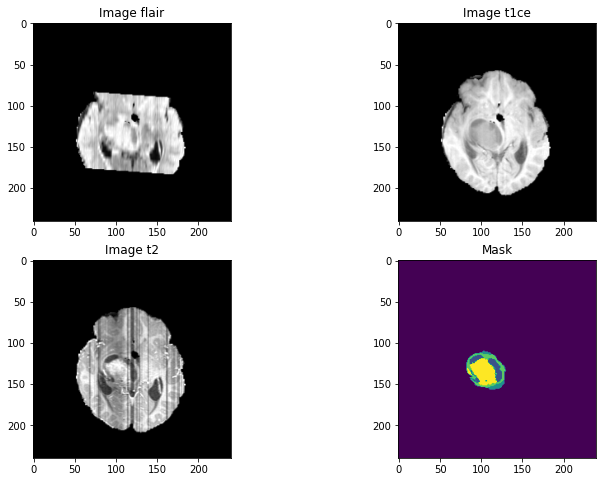

In [ ]:
image_ground_truth=np.argmax(ground_truth, axis=2)

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(image[:,:, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(image[:,:, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(image[:,:, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(image_ground_truth[:,:])
plt.title('Mask')
plt.show()

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation
from keras.layers import ZeroPadding2D, ZeroPadding1D
from keras import backend as K

In [ ]:
################################################################
def multi_unet_model(n_classes=5, IMG_HEIGHT=240, IMG_WIDTH=240, IMG_CHANNELS=4):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [ ]:
from keras.layers import Dense, Flatten, Reshape

In [ ]:
################################################################
def custom_model(n_classes=5, IMG_HEIGHT=240, IMG_WIDTH=240, IMG_CHANNELS=4):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    #c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    #c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    #c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    #c4 = Dropout(0.2)(c4)
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    
    
    F1 = Flatten()(p4)

    size = F1.shape[1]


    D1 = Dense(size, activation = 'relu', kernel_initializer='he_uniform')(F1)

    D2 = Dense(size, activation = 'relu', kernel_initializer='he_uniform')(D1)

    #D2 = Dense(size, activation = 'relu', kernel_initializer='he_uniform')(D2)

    R1 = Reshape((p4.shape[1],p4.shape[2],p4.shape[3]))(D2)


    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(R1)
    
    c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    #c6 = Dropout(0.2)(c6)
    c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)


    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    
    c7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    #c7 = Dropout(0.2)(c7)
    c7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)

    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    #c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)


    
     
    
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()

    return model



In [ ]:
################################################################
def custom_segnet(n_classes=5, IMG_HEIGHT=240, IMG_WIDTH=240, IMG_CHANNELS=4):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    s = inputs

    # Contraction path ----------------------------------------- ENCODER -------------------------------------------------

    # Level 1

    
    
    conv_1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)

    conv_1 = Conv2D(32, (3, 3), padding="same", kernel_initializer='he_normal')(conv_1)
    BN_1 = BatchNormalization()(conv_1)
    BN_1 = Activation("relu")(BN_1)

    pool_1 = MaxPooling2D(pool_size=(2, 2))(BN_1)

    conv_1 = Conv2D(32, (3, 3), activation='relu', padding="same", kernel_initializer='he_normal')(pool_1)

    # Level 2

    conv_2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_1)

    conv_2 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal')(conv_2)
    BN_2 = BatchNormalization()(conv_2)
    BN_2 = Activation("relu")(BN_2)

    pool_2 = MaxPooling2D(pool_size=(2, 2))(BN_2)

    conv_2 = Conv2D(64, (3, 3), activation='relu', padding="same", kernel_initializer='he_normal')(pool_2)

    #concatination

    concat_1 = MaxPooling2D(pool_size=(2, 2))(BN_1)
    concat_1 = MaxPooling2D(pool_size=(2, 2))(concat_1)
    
    concat_1 = concatenate([conv_2,concat_1])



    # Level 3


    conv_3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_1)

    conv_3 = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal')(conv_3)
    BN_3 = BatchNormalization()(conv_3)
    BN_3 = Activation("relu")(BN_3)

    pool_3 = MaxPooling2D(pool_size=(2, 2))(BN_3)

    conv_3 = Conv2D(128, (3, 3), activation='relu', padding="same", kernel_initializer='he_normal')(pool_3)


    #concatination

    concat_2 = MaxPooling2D(pool_size=(2, 2))(BN_2)
    concat_2 = MaxPooling2D(pool_size=(2, 2))(concat_2)
    
    concat_2 = concatenate([conv_3,concat_2])


    
    # Level 4


    conv_4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_2)

    conv_4 = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal')(conv_4)
    BN_4 = BatchNormalization()(conv_4)
    BN_4 = Activation("relu")(BN_4)

    pool_4 = MaxPooling2D(pool_size=(2, 2))(BN_4)

    conv_4 = Conv2D(256, (3, 3), activation='relu', padding="same", kernel_initializer='he_normal')(pool_4)


    #concatination

    concat_3 = MaxPooling2D(pool_size=(2, 2))(BN_3)
    concat_3 = MaxPooling2D(pool_size=(2, 2))(concat_3)
    
    concat_3 = concatenate([conv_4,concat_3])


    # Level 5


    conv_5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_3)

    conv_5 = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal')(conv_5)
    BN_5 = BatchNormalization()(conv_5)
    BN_5 = Activation("relu")(BN_5)

    pool_5 = MaxPooling2D(pool_size=(2, 2))(BN_5)

    conv_5 = Conv2D(512, (3, 3), activation='relu', padding="same", kernel_initializer='he_normal')(pool_5)


    #concatination

    concat_4 = MaxPooling2D(pool_size=(2, 2))(BN_4)
    concat_4 = MaxPooling2D(pool_size=(2, 2))(concat_4)
    
    concat_4 = concatenate([conv_5,concat_4])

    concat_4 = ZeroPadding2D(padding=((0,0),(0,0)))(concat_4)



    # Expansion path ----------------------------------------- DECODER -------------------------------------------------
    
    # Level 1

    upsamp_1 = UpSampling2D(size=(2,2))(concat_4)

    upsamp_1 = ZeroPadding2D(padding=((0,1),(0,1)))(upsamp_1)

    conv_6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsamp_1)

    conv_6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_6)

    conv_6 = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal')(conv_6)
    BN_6 = BatchNormalization()(conv_6)

    BN_6 = Activation("relu")(BN_6)


    # Level 2

    upsamp_2 = UpSampling2D(size=(2,2))(BN_6) #upsampling increases the size of feature maps 64x64 -> 128x128 

    conv_7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsamp_2)
    conv_7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_7)

    conv_7 = BatchNormalization()(conv_7)

    conv_7 = Activation("relu")(conv_7)


    #concatination

    concat_5 = ZeroPadding2D(padding=((0,0),(0,0)))(BN_4)

    concat_5 = concatenate([conv_7,concat_5])

    conv_7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_5)



    # Level 3

    upsamp_3 = UpSampling2D(size=(2,2))(conv_7)

    conv_8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsamp_3)
    conv_8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_8)

    conv_8 = BatchNormalization()(conv_8)

    conv_8 = Activation("relu")(conv_8)


    #concatination

    concat_6 = ZeroPadding2D(padding=((0,0),(0,0)))(BN_3)

    concat_6 = concatenate([conv_8,concat_6])

    conv_8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_6)


    # Level 4

    upsamp_4 = UpSampling2D(size=(2,2))(conv_8)

    conv_9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsamp_4)
    conv_9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_9)

    conv_9 = BatchNormalization()(conv_9)

    conv_9 = Activation("relu")(conv_9)


    #concatination

    concat_7 = ZeroPadding2D(padding=((0,0),(0,0)))(BN_2)

    concat_7 = concatenate([conv_9,concat_7])

    conv_9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_7)

    
    # Level 5

    upsamp_5 = UpSampling2D(size=(2,2))(conv_9)

    conv_10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsamp_5)
    conv_10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_10)

    conv_10 = BatchNormalization()(conv_10)

    conv_10 = Activation("relu")(conv_10)


    #concatination

    concat_8 = ZeroPadding2D(padding=((0,0),(0,0)))(BN_1)

    concat_8 = concatenate([conv_10,concat_8])

    conv_10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_8)
    

    
     
    
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv_10)
     
    model = Model(inputs=[inputs], outputs=[outputs]) # 240 x 240 x 5
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()

    return model

In [ ]:
model = custom_segnet(n_classes=5, IMG_HEIGHT=240, IMG_WIDTH=240, IMG_CHANNELS=4)

print(model.summary())

Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 240, 240, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1057 (Conv2D)           (None, 240, 240, 32  1184        ['input_47[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_1058 (Conv2D)           (None, 240, 240, 32  9248        ['conv2d_1057[0][0]']            
                                )                                                          

In [ ]:
!pip install segmentation_models
import segmentation_models as sm



IOU_score = sm.metrics.IOUScore(threshold=0.5)

weights = [0.2, 0.2, 0.2, 0.2, 0.2]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #

learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model = multi_unet_model(n_classes=5,IMG_HEIGHT=240,IMG_WIDTH=240,IMG_CHANNELS=4)



model.compile(optimizer=optimizer, loss=total_loss, metrics=['accuracy' , IOU_score])

In [ ]:
print(model.summary())

In [ ]:
X = []
Y = []

X.append(image)
Y.append(ground_truth)

X = np.array(X)
Y = np.array(Y)


history=model.fit(X,Y,
          steps_per_epoch=1,
          epochs=500,
          verbose=1,
          )

model.save('/content/drive/MyDrive/custom_segnet_model.hdf5')

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 1.0309 - accuracy: 0.3255 - iou_score: 0.0189
Epoch 2/500
1/1 [==============================] - 0s 26ms/step - loss: 1.0180 - accuracy: 0.5702 - iou_score: 0.0509
Epoch 3/500
1/1 [==============================] - 0s 27ms/step - loss: 1.0123 - accuracy: 0.7810 - iou_score: 0.0371
Epoch 4/500
1/1 [==============================] - 0s 28ms/step - loss: 0.9956 - accuracy: 0.8496 - iou_score: 0.0913
Epoch 5/500
1/1 [==============================] - 0s 28ms/step - loss: 0.9930 - accuracy: 0.8903 - iou_score: 0.1572
Epoch 6/500
1/1 [==============================] - 0s 28ms/step - loss: 0.9871 - accuracy: 0.9409 - iou_score: 0.1780
Epoch 7/500
1/1 [==============================] - 0s 28ms/step - loss: 0.9837 - accuracy: 0.9580 - iou_score: 0.1856
Epoch 8/500
1/1 [==============================] - 0s 28ms/step - loss: 0.9761 - accuracy: 0.9648 - iou_score: 0.1871
Epoch 9/500
1/1 [==============================] - 0s 29ms

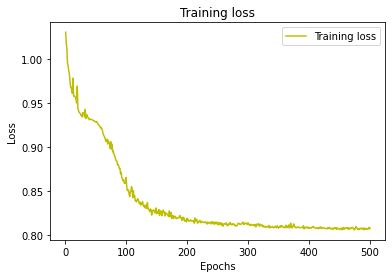

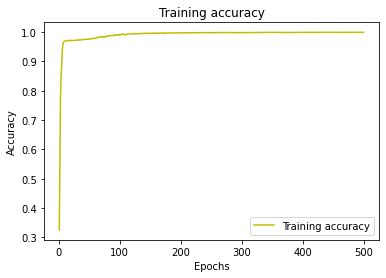

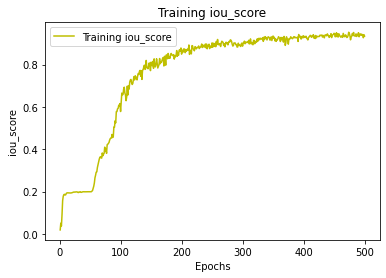

In [ ]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


acc = history.history['iou_score']

plt.plot(epochs, acc, 'y', label='Training iou_score')
plt.title('Training iou_score')
plt.xlabel('Epochs')
plt.ylabel('iou_score')
plt.legend()
plt.show()


(240, 240, 4)
(1, 240, 240, 4)
(1, 240, 240, 5)
(240, 240)
-----
(240, 240, 5)


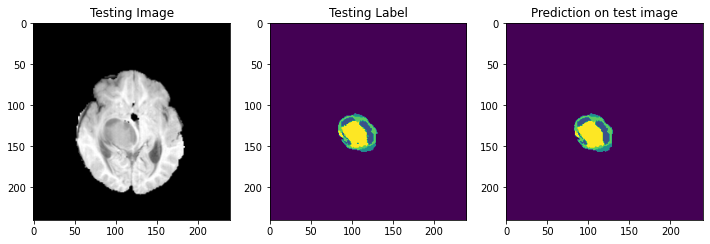

[0 1 2 3 4]


In [ ]:
from keras.models import load_model

my_model = load_model('/content/drive/MyDrive/custom_segnet_model.hdf5', compile=False)

print(my_model)

print()

mri_image = X[0]

print(mri_image.shape)

test_img_input = np.expand_dims(mri_image, axis=0)

print(test_img_input.shape)

test_prediction = my_model.predict(test_img_input)

print(test_prediction.shape)

test_prediction_argmax=np.argmax(test_prediction, axis=3)[0,:,:]

print(test_prediction_argmax.shape)

prediction = test_prediction_argmax


img_ground_truth = Y[0]


print("-----")

#ground_truth = np.expand_dims(ground_truth, axis=2)

print(img_ground_truth.shape)


img_ground_truth=np.argmax(img_ground_truth, axis=2)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(mri_image[:,:,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(img_ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction[:,:])
plt.show()

print(np.unique(prediction))

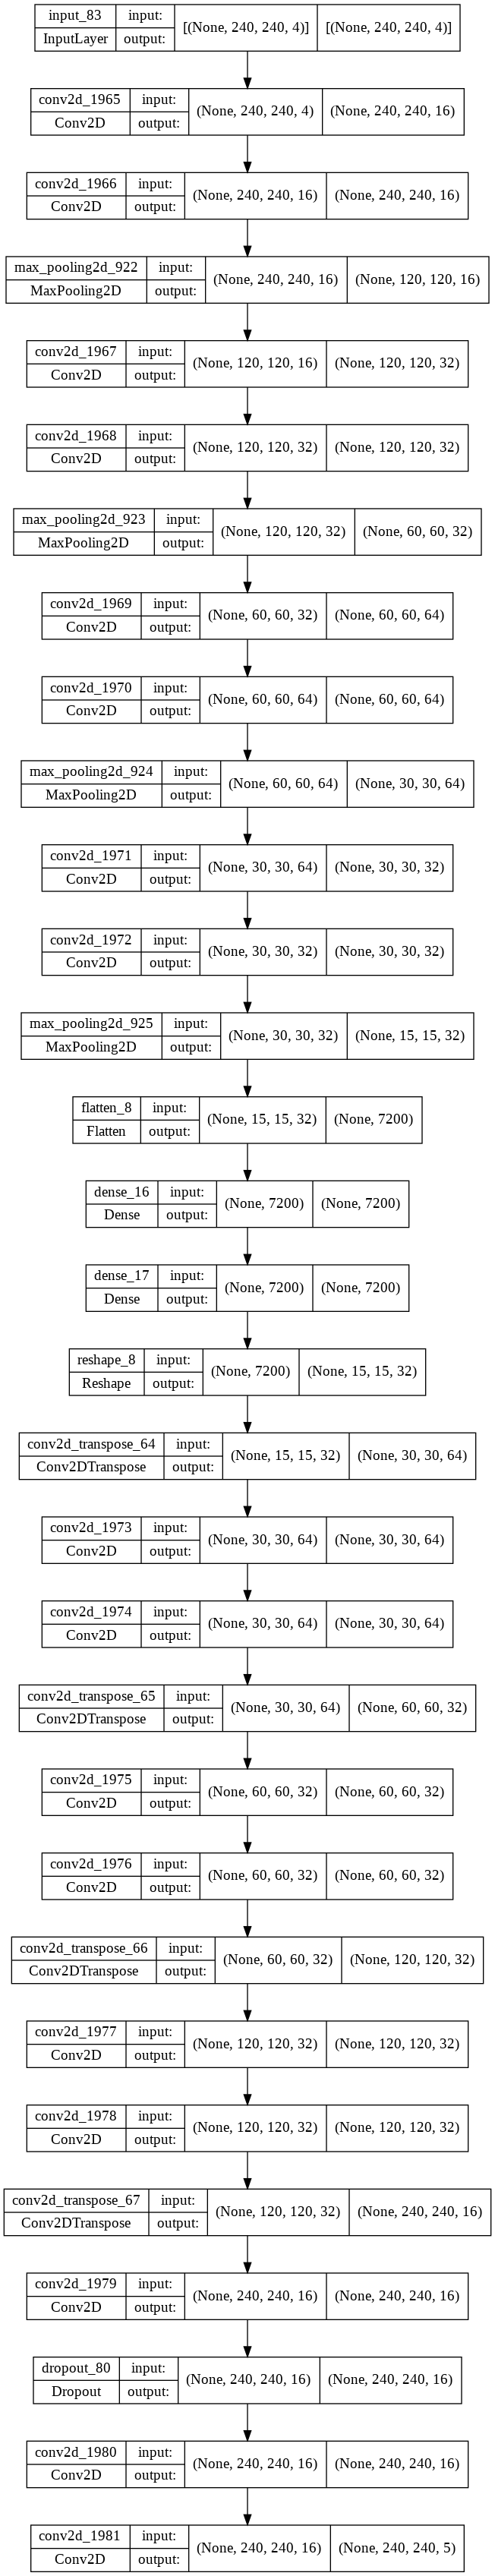

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)